In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv


# Forecasting future sales using Machine Learning

Forecasting future sales of a product offers many advantages. Predicting future sales of a product helps a company manage the cost of manufacturing and marketing the product. In this notebook, I will try to you through the task of future sales prediction with machine learning using Python.

In [2]:
# EDA Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit-Learn models
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM

import statsmodels.api as sm

import pickle
import datetime
from pathlib import Path  

## **Loading Dataset & Data Exploration (EDA)** 

> The first step is to load the data and transform it into a structure that we will then use for each of our models. In its raw form, each row of data represents a single day of sales at one of ten stores. Our goal is to predict monthly sales, so we will first consolidate all stores and days into total monthly sales.

In [3]:
dataset = pd.read_csv('../input/demand-forecasting-kernels-only/sample_submission.csv')
df = dataset.copy()
df.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


In [4]:
sales_data = pd.read_csv('../input/demand-forecasting-kernels-only/train.csv')
df_s = sales_data.copy()
df_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [5]:
df_s.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [6]:
df_s.index

RangeIndex(start=0, stop=913000, step=1)

In [7]:
#To view basic statistical details about dataset:

df_s.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


 <div class="alert alert-block alert-danger">
    <p style="padding: 10px;
              color:black;">Sales seem to be unbalanced.
    </p>
  </div>

<AxesSubplot:>

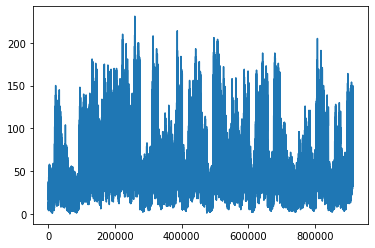

In [8]:
df_s['sales'].plot()

> Returns a dataframe where each row represents total sales for a given month. Columns include 'date' by month and 'sales'.
    

In [9]:
def monthly_sales(data):
    m_data = data.copy()
    
    # Drop the day indicator from the date column:
    m_data.date = m_data.date.apply(lambda x: str(x)[:-3])
   
    # Sum sales per month: 
    m_data = m_data.groupby('date')['sales'].sum().reset_index()
    m_data.date = pd.to_datetime(m_data.date)
    
    filepath = Path('../data/monthly_data.csv')  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    m_data.to_csv('../data/monthly_data.csv')
    
    return m_data

m_df = monthly_sales(df_s)
m_df.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


> In our new data frame, each row now represents the total sales for a given month across stores.

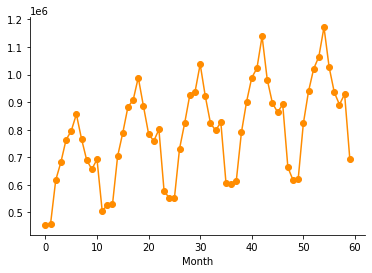

In [10]:
m_df['sales'].plot(marker = 'o',color = 'darkorange')
plt.xlabel("Month")

sns.despine()

<div class="alert alert-block alert-danger">
    <p style="padding: 10px;
              color:black;">If we plot the total monthly sales over time, we see that the average monthly sales increase over time, so our data is not stationary.
    </p>
</div>

[🦎 TREND AND SEASONALITY](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646)
> There are many other models to forecast time series, such as weighted
moving average models or autoregressive integrated moving average
(ARIMA) models. Some of them require you to first remove the trend
and seasonality. For example, if you are studying the number of active
users on your website, and it is growing by 10% every month, you
would have to remove this trend from the time series. Once the model
is trained and starts making predictions, you would have to add the
trend back to get the final predictions. Similarly, if you are trying to
predict the amount of sunscreen lotion sold every month, you will
probably observe strong seasonality: since it sells well every summer,
a similar pattern will be repeated every year. You would have to
remove this seasonality from the time series, for example by
computing the difference between the value at each time step and the
value one year earlier (this technique is called differencing). Again,
after the model is trained and makes predictions, you would have to
add the seasonal pattern back to get the final predictions.


# **Data Exploration (EDA)**

> To make it stationary, we will calculate the difference between the sales of each month and add it to our data frame as a new column.
> Further details of the stationary and differences are available [here.](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) But first let's take a closer look at the data set you work with by learning more about the data.

In [11]:
# Time interval of dataset:
def sales_time(data):
    data.date = pd.to_datetime(data.date)
    n_of_days = data.date.max() - data.date.min()
    n_of_years = int(n_of_days.days / 365)
    
    print('Days:', n_of_days.days)
    print('Years:', n_of_years)
    print('Month:', 12*n_of_years)
    
    
sales_time(df_s)


Days: 1825
Years: 5
Month: 60


**Sales Data Per Store**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,store,sales
0,1,4315603
1,2,6120128
2,3,5435144
3,4,5012639
4,5,3631016
5,6,3627670
6,7,3320009
7,8,5856169
8,9,5025976
9,10,5360158


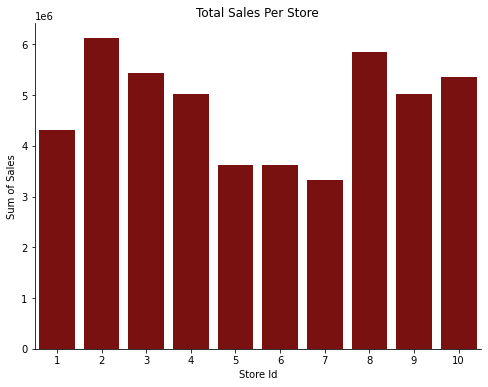

In [12]:
# Let's sell it per store:
def sales_per_store(data):
    sales_by_store = data.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(sales_by_store.store, sales_by_store.sales, color='darkred')
    
    ax.set(xlabel = "Store Id", ylabel = "Sum of Sales", title = "Total Sales Per Store")
    
    sns.despine() 
    return sales_by_store
    
sales_per_store(df_s)

**Mean Monthly Sales**

In [13]:
# Overall for 5 years:

average_m_sales = m_df.sales.mean()
print(f"Overall Avarage Monthly Sales: ${average_m_sales}")

#Last 1 years (this will be the forecasted sales):

average_m_sales_1y = m_df.sales[-12:].mean()
print(f"Last 12 months average monthly sales: ${average_m_sales_1y}")



Overall Avarage Monthly Sales: $795075.2
Last 12 months average monthly sales: $894478.3333333334


# **Determining Time Series Stationary**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


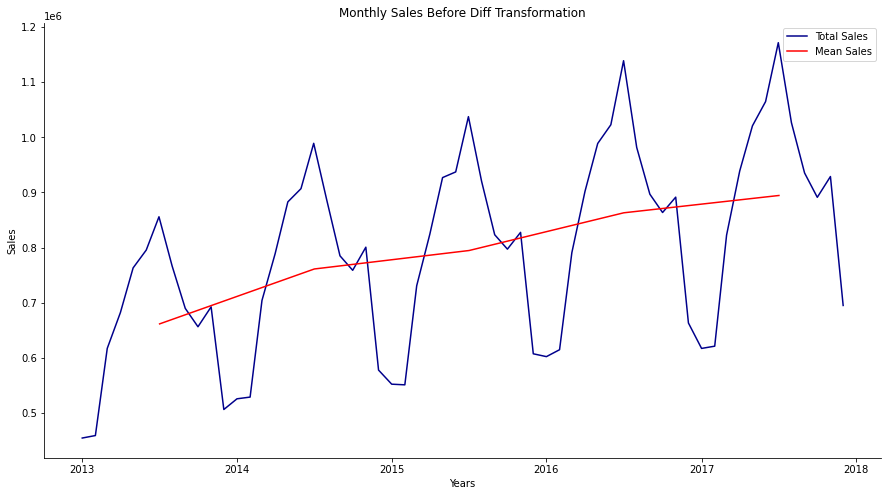

In [14]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize = (15,8))
    sns.lineplot(x_col, y_col, data = data, ax = ax, color = 'darkblue', label='Total Sales')
    
    s_mean = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    s_mean.date = pd.to_datetime(s_mean.date, format='%Y')
    sns.lineplot((s_mean.date + datetime.timedelta(6*365/12)), y_col, data=s_mean, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Years",
           ylabel = "Sales",
           title = title)
    
    sns.despine()
    

time_plot(m_df, 'date', 'sales', 'Monthly Sales Before Diff Transformation' )

**Differencing**

> In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


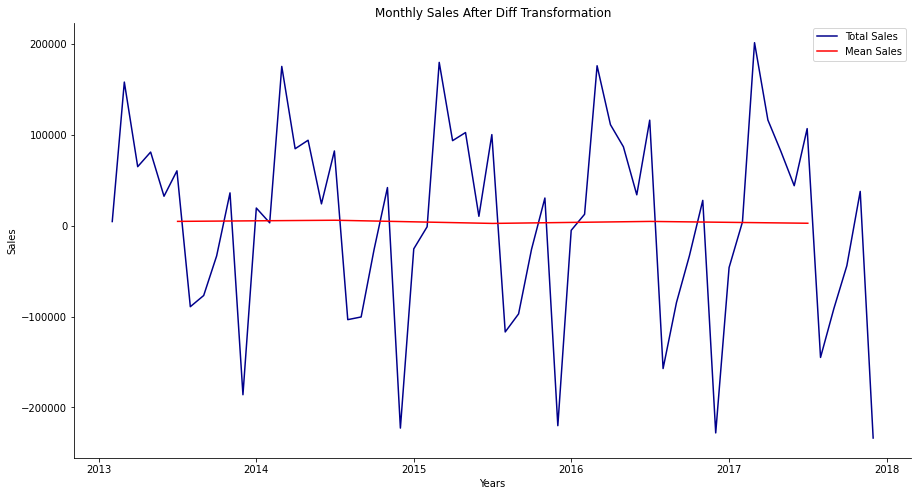

In [15]:
# Calculate the difference in sales month over month:

def get_diff(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    filepath = Path('../data/stationary_df.csv')  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    data.to_csv('../data/stationary_df.csv')
    
    return data

stationary_df = get_diff(m_df)
time_plot(stationary_df, 'date', 'sales_diff', 'Monthly Sales After Diff Transformation')


<div class="alert alert-block alert-info">
    <p style="padding: 10px;
              color:black;">Now that our data represent monthly sales and we have transformed it to be stationary, we will set up the 
                            data for our different model types. <br>
        To do this, we will 
                            define two different structures: 
        <br>
            1. one will be used for ARIMA modeling,
        <br>
            2. the other will be used for the rest of the models.
     </p>
   </div>
